<a href="https://colab.research.google.com/github/chisomrutherford/ecom_steps/blob/master/Welo_Health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Authenticate Google Account

In [ ]:

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)


## Import the data from Google sheet

In [ ]:
#name_of_sheet= 'Umvuzo-Cape Point-2 July 2024 (Responses)'

sheet_name = input("Enter the name of the sheet: ")
name_of_sheet = sheet_name

Enter the name of the sheet: Umvuzo - South 32 - 19 March 2025  (Responses)


## Data Processing

In [ ]:
responses = gc.open(name_of_sheet)

# Select the worksheet (index 0== the first work sheet)
worksheet = responses.get_worksheet(0)

# Get all values from the worksheet
rows = worksheet.get_all_values()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors
%matplotlib inline

In [ ]:
%%capture
df = pd.DataFrame.from_records(rows[1:], columns=rows[0])
df.head(30)

In [ ]:
%%capture

new_df= df.drop(['Timestamp', 'NURSE NAME', 'MEDICAL AID NUMBER', 'MEDICAL AID PLAN', 'FIRST NAMES', 'SURNAME'], axis= 1)
new_df.head()

In [ ]:
#@title Create a column for bmi
%%capture

new_df['HEIGHT(cm) '] = pd.to_numeric(new_df['HEIGHT(cm) '], errors='coerce')
new_df['WEIGHT (kg) *'] = pd.to_numeric(new_df['WEIGHT (kg) *'], errors='coerce')
new_df['BMI'] = new_df['WEIGHT (kg) *'] / ((new_df['HEIGHT(cm) '] / 100) ** 2)
new_df.head(10)

## Charts

<ipython-input-46-5e2d03158959>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=gender_counts.index, y=gender_counts.values, palette=['teal', 'coral'])


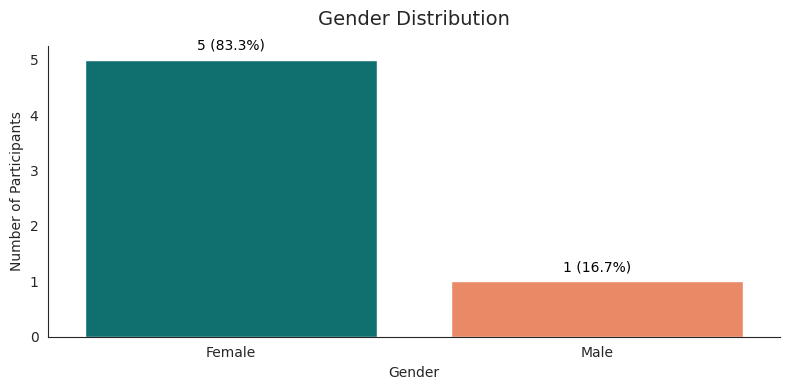

In [ ]:
#@title Gender Distribution
def gender(sex):
    """Categorizes gender into 'Male', 'Female', or None."""
    return sex if sex in ('Male', 'Female') else None

new_df['Gender Cat'] = new_df['GENDER'].apply(gender)

sns.set_style("white")
plt.figure(figsize=(8, 4))

gender_counts = new_df['Gender Cat'].value_counts()
total_participants = len(new_df)
gender_percentages = (gender_counts / total_participants) * 100

ax = sns.barplot(x=gender_counts.index, y=gender_counts.values, palette=['teal', 'coral'])
plt.xlabel("Gender")
plt.ylabel("Number of Participants")
plt.title("Gender Distribution", fontsize=14, pad=15)

for bar, percentage, count in zip(ax.patches, gender_percentages, gender_counts):
    annotation = f'{count} ({percentage:.1f}%)'
    x_pos = bar.get_x() + bar.get_width() / 2
    y_pos = bar.get_height()
    ax.annotate(annotation, (x_pos, y_pos), ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

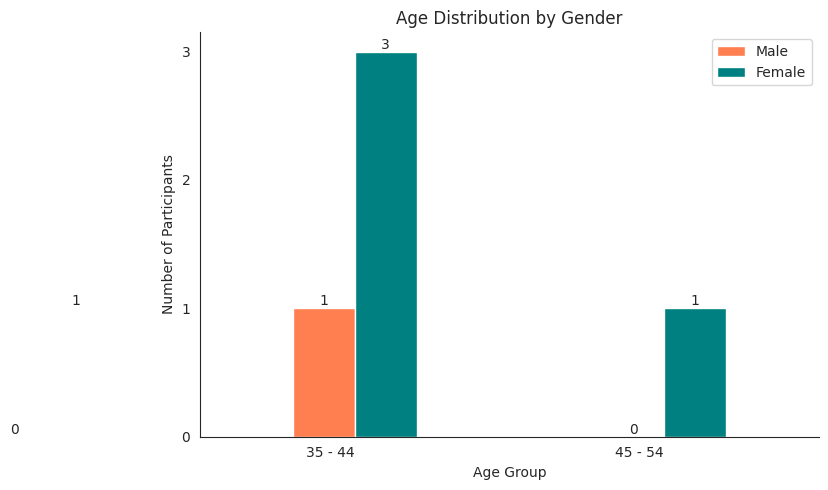

In [ ]:
#@title Barchart representing age distribution of males and females

age_gender_counts = new_df.groupby(['AGE GROUP', 'GENDER']).size().unstack(fill_value=0)

bar_width = 0.2
index = np.arange(len(age_gender_counts.index))

plt.figure(figsize=(7,5))  # Adjust figure size for better visualization

# Plotting Male counts
male_bars = plt.bar(index - bar_width / 2, age_gender_counts['Male'], bar_width, label='Male', color='coral')

# Plotting Female counts
female_bars = plt.bar(index + bar_width / 2, age_gender_counts['Female'], bar_width, label='Female', color='teal')

plt.xlabel('Age Group')
plt.ylabel('Number of Participants')
plt.title('Age Distribution by Gender')
plt.xticks(index, age_gender_counts.index, ha='right')
plt.legend()
plt.tight_layout()
plt.xlim(0.5, len(age_gender_counts.index) -0.5)

plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))

for bar in male_bars + female_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, int(height),
             ha='center', va='bottom')

sns.despine(top=True, right=True)
plt.show()

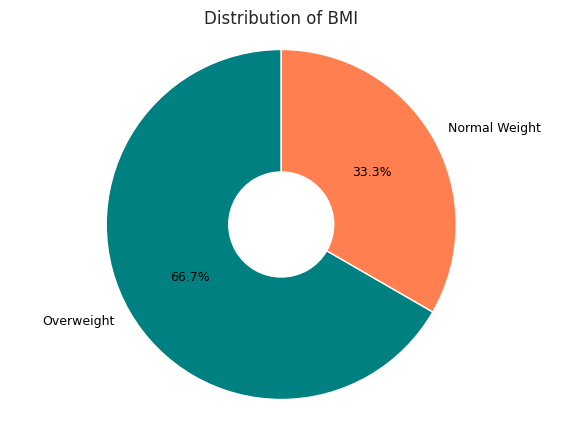

In [ ]:
#@title BMI Chart

def classify_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 24.9:
        return 'Normal Weight'
    else:
        return 'Overweight'

new_df['BMI Category'] = new_df['BMI'].apply(classify_bmi)
bmi_counts = new_df['BMI Category'].value_counts()

plt.figure(figsize=(7, 5))
#explode = (0, 0, 0.06)

cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["red", "yellow", "green"])
colors = cmap(np.linspace(0, 1, len(bmi_counts)))
plt.pie(bmi_counts,
        labels=bmi_counts.index,
        autopct='%1.1f%%',
        startangle=90, colors=(['teal', 'coral', 'orange']),
        wedgeprops={'linewidth': 1, 'edgecolor': 'white', 'width': 0.7},
        textprops={'fontsize': 9, 'color': 'black', 'weight': 'normal'})
plt.title('Distribution of BMI')

plt.axis('equal')
plt.show()

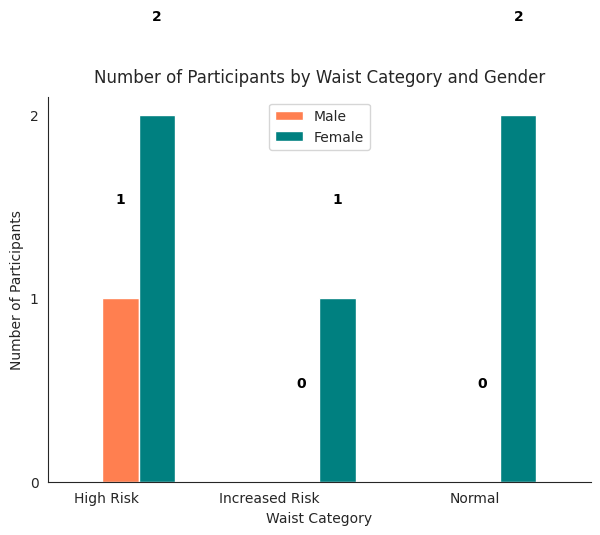

In [ ]:
#@title Bar Chart of Gender and Waist Circumference Distribution

#waist_circumference_age = new_df.groupby(['Waist Category', 'GENDER']).size().unstack(fill_value=0)

# Group men and women based on waist circumference
def male_waist(waists):

    try:
        waists = float(waists)
    except ValueError:
        return None

    if waists < 94:
        return 'Normal'
    elif 94< waists < 102:
        return 'Increased Risk'
    elif waists> 102:
        return 'High Risk'
    else:
      return None

def female_waist (waist):

    try:
        waist = float(waist)
    except ValueError:
        return None

    if waist < 80:
        return 'Normal'
    elif 80< waist < 88:
        return 'Increased Risk'
    elif waist>= 88:
        return 'High Risk'
    else:
        return None

def categorize_waist(waist, gender):
    if gender == 'Male':
        return male_waist(waist)
    elif gender == 'Female':
        return female_waist(waist)
    else:
        return None

new_df['Waist Category'] = new_df.apply(lambda row: categorize_waist(row['WAIST CIRCUMFERENCE (cm) '], row['Gender Cat']), axis=1)
waist_circumference_age = new_df.groupby(['Waist Category', 'GENDER']).size().unstack(fill_value=0)

men = new_df[new_df['Gender Cat'] == 'Male']
women = new_df[new_df['Gender Cat'] == 'Female']

men_waist_counts = men['Waist Category'].value_counts()
women_waist_counts = women['Waist Category'].value_counts()

#print(f"Men Waist Circumference: ", men_waist_counts)
#print(f"\nWomen Waist Circumference: ", women_waist_counts)

bar_width = 0.2
index = np.arange(len(waist_circumference_age.index))

plt.figure(figsize=(7, 5))
# Plotting Male counts
plt.bar(index - bar_width / 2, waist_circumference_age['Male'], bar_width, label='Male', color='coral')

# Plotting Female counts
plt.bar(index + bar_width / 2, waist_circumference_age['Female'], bar_width, label='Female', color='teal')

plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))

for gender, color in [('Male', 'coral'), ('Female', 'teal')]:
    for i, count in enumerate(waist_circumference_age[gender]):
        plt.text(i - bar_width / 2 if gender == 'Male' else i + bar_width / 2,
                 count + 0.5,
                 int(count),
                 ha='center', va='bottom',
                 color='black', fontweight='bold')

plt.xlabel('Waist Category')
plt.ylabel('Number of Participants')
plt.title('Number of Participants by Waist Category and Gender', pad= 10)
plt.xticks(index, waist_circumference_age.index, ha='right')
plt.legend()
#plt.tight_layout()
plt.xlim(-0.5, len(waist_circumference_age.index) - 0.5)
sns.despine(top=True, right=True)

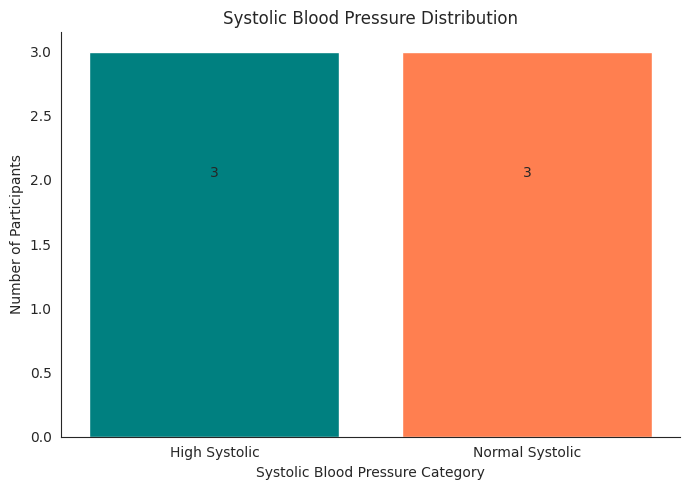

In [ ]:
# @title Bar Chart of Systolic Blood Pressure

new_df['SYSTOLIC BLOOD PRESSURE (top reading)'] = pd.to_numeric(new_df['SYSTOLIC BLOOD PRESSURE (top reading)'], errors='coerce').astype('Int64')

def sys_blood_pressure (sbp):
  try:
    #sbp= int(sbp)
    if 110<= sbp <=139:
      return 'Normal Systolic'
    elif 70< sbp <110:
      return 'Low Systolic'
    elif 140< sbp <180 :
      return 'High Systolic'
    else:
      return None
  except ValueError:
    return 'Invalid Input'

new_df['SBP Category'] = new_df['SYSTOLIC BLOOD PRESSURE (top reading)'].apply(sys_blood_pressure)
sbf_counts = new_df['SBP Category'].value_counts()

# Creating the bar chart
plt.figure(figsize=(7, 5))
bars = plt.bar(sbf_counts.index, sbf_counts.values, color=['teal', 'coral', 'orange'])
plt.xlabel("Systolic Blood Pressure Category")
plt.ylabel("Number of Participants")
plt.title("Systolic Blood Pressure Distribution")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height - 1.0, height,
             ha='center', va='bottom')
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

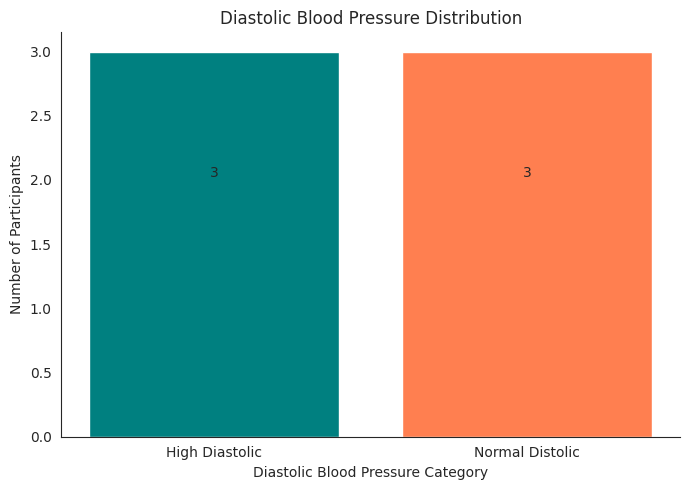

In [ ]:
#@title Bar Chart of Diastolic Blood Presure

new_df['DIASTOLIC BLOOD PRESSURE (bottom reading)'] = pd.to_numeric(new_df['DIASTOLIC BLOOD PRESSURE (bottom reading)'], errors='coerce').astype('Int64')

def dia_blood_pressure (dbp):
  try:
    #sbp= int(sbp)
    if 60<=dbp<=80:
      return 'Normal Distolic'
    elif 40<dbp<60:
      return 'Low Diastolic'
    elif 80<dbp<150 :
      return 'High Diastolic'
    else:
      return None
  except ValueError:
    return 'Invalid Input'

new_df['DBP Category'] = new_df['DIASTOLIC BLOOD PRESSURE (bottom reading)'].apply(dia_blood_pressure)
sbf_counts = new_df['DBP Category'].value_counts()

plt.figure(figsize=(7, 5))
bars = plt.bar(sbf_counts.index, sbf_counts.values, color=['teal', 'coral', 'orange'])

plt.xlabel("Diastolic Blood Pressure Category")
plt.ylabel("Number of Participants")
plt.title("Diastolic Blood Pressure Distribution")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height -1.0, height, ha='center', va='bottom')
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

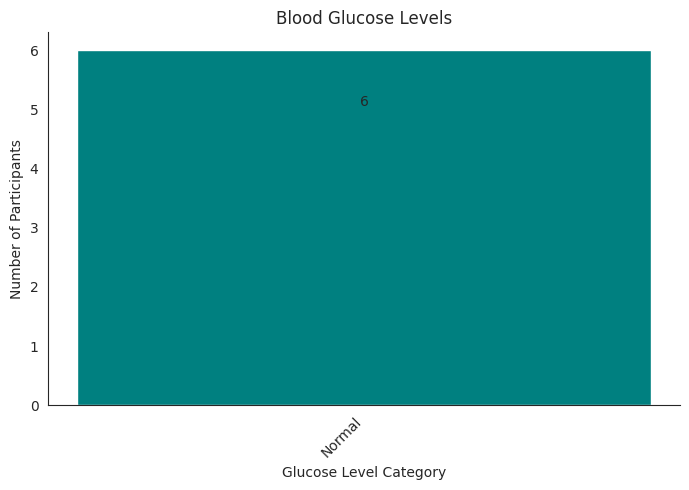

In [ ]:
#@title Bar Chart of Random Glucose Level
new_df['GLUCOSE (mmol/l)'] = pd.to_numeric(new_df['GLUCOSE (mmol/l)'], errors='coerce').astype('float')

def blood_glucose (glucose):
  try:
    if glucose>11.1:
      return 'High Glucose Level'
    elif 3.5<= glucose <=11.1:
      return 'Normal'
    elif glucose<3.5:
      return 'Low Glucose'
    else:
      return None
  except ValueError:
    return 'Invalid Input'

new_df['Glucose Category'] = new_df['GLUCOSE (mmol/l)'].apply(blood_glucose)
# Calculate the value counts for each glucose category
glucose_level = new_df['Glucose Category'].value_counts()

plt.figure(figsize=(7, 5))
# Create the bar chart
bars = plt.bar(glucose_level.index, glucose_level.values, color=['teal', 'coral', 'orange', 'lightblue'])

plt.xlabel("Glucose Level Category")
plt.ylabel("Number of Participants")
plt.title("Blood Glucose Levels")

# Add labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height -1.0, height,
             ha='center', va='bottom')

sns.despine(top=True, right=True)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

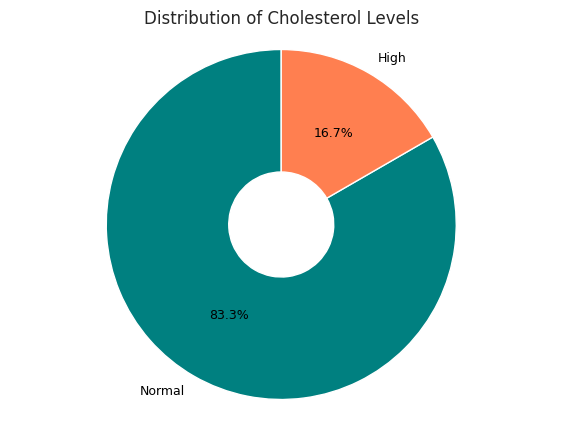

In [ ]:
#@title Pie Chart of Cholesterol Levels

new_df['CHOLESTEROL (mmol/l)'] = pd.to_numeric(new_df['CHOLESTEROL (mmol/l)'], errors='coerce').astype('float')


def categorize_cholesterol(cholesterol):
    if cholesterol < 5.2:
        return 'Normal'
    elif cholesterol> 5.2:
        return 'High'
    else:
        return None

new_df['Cholesterol Category'] = new_df['CHOLESTEROL (mmol/l)'].apply(categorize_cholesterol)

cholesterol_counts = new_df['Cholesterol Category'].value_counts()

plt.figure(figsize=(7, 5))
wedges, texts, autotexts = plt.pie(cholesterol_counts,
        labels=cholesterol_counts.index,
        autopct='%1.1f%%',
        startangle=90, colors=(['teal', 'coral', 'orange']),
        wedgeprops={'linewidth': 1, 'edgecolor': 'white', 'width': 0.7},
        textprops={'fontsize': 9, 'color': 'black', 'weight': 'normal'})


plt.title('Distribution of Cholesterol Levels')
plt.axis('equal')
plt.show()

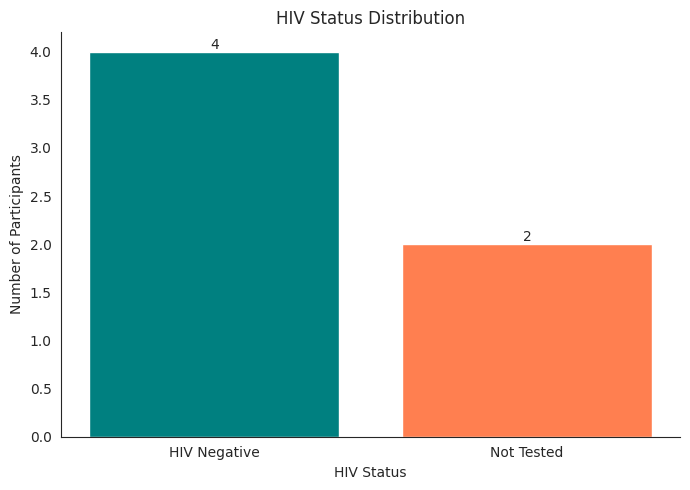

In [ ]:
#@title Bar Chart of HIV Status

def HIV_status(status):
  if status == 'Positive':
    return 'HIV Positive '
  elif status == 'Negative':
    return 'HIV Negative'
  elif status == 'Not tested':
    return 'Not Tested'
  else:
    return None

new_df['HIV Status'] = new_df['HIV '].apply(HIV_status)
hiv_status = new_df['HIV Status'].value_counts()

plt.figure(figsize=(7, 5))  # Adjust figure size if needed

bars = plt.bar(hiv_status.index, hiv_status.values, color=['teal', 'coral', 'orange'])

plt.xlabel("HIV Status")
plt.ylabel("Number of Participants")
plt.title("HIV Status Distribution")

# Add labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height,
             ha='center', va='bottom')

sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

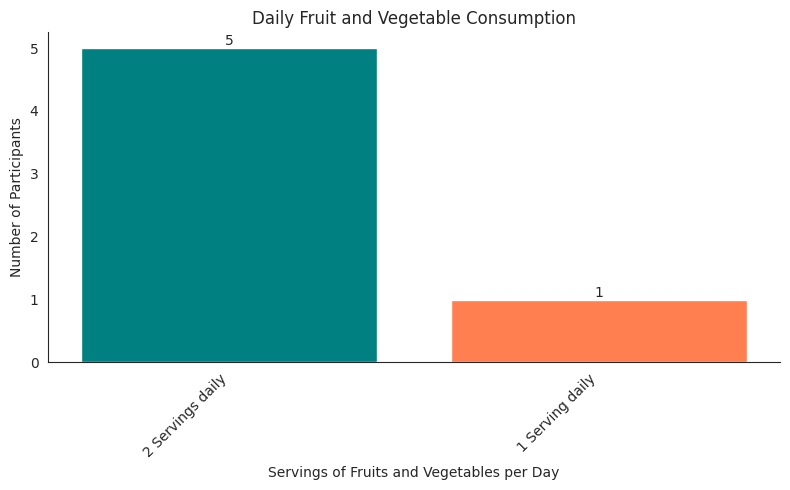

In [ ]:
#@title Servings of Fruits Per Day

new_df['How many servings of fruits and vegetables do you eat every day?'] = pd.to_numeric(new_df['How many servings of fruits and vegetables do you eat every day?'], errors='coerce').fillna(0).astype(np.int64)

def fruit_veg(fv):
  if fv < 1:
    return 'None'
  elif fv == 1:
    return '1 Serving daily'
  elif fv == 2:
    return '2 Servings daily'
  elif fv >= 3:
    return '3 or more Servings daily'
  else:
    return None

new_df['Fruit and Veg'] = new_df['How many servings of fruits and vegetables do you eat every day?'].apply(fruit_veg)

fruit_veg_counts = new_df['Fruit and Veg'].value_counts()

plt.figure(figsize=(8, 5))

bars = plt.bar(fruit_veg_counts.index, fruit_veg_counts.values, color=['teal', 'coral', 'orange', 'lightblue', 'red'])

plt.xlabel("Servings of Fruits and Vegetables per Day")
plt.ylabel("Number of Participants")
plt.title("Daily Fruit and Vegetable Consumption")

plt.xticks(rotation=45, ha="right")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

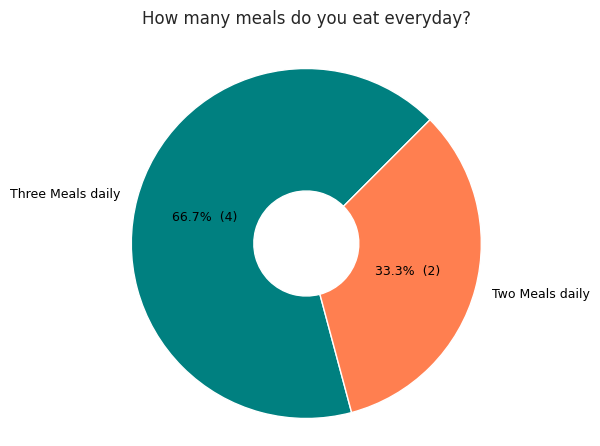

In [ ]:
#@title Number of Meals Per Day
new_df['How many meals do you eat everyday?'] = pd.to_numeric(new_df['How many meals do you eat every day?'], errors='coerce').fillna(0).astype(np.int64)

def number_of_meals (meals):
  if meals<1:
    return None
  elif meals==1:
    return 'One Meal daily'
  elif meals==2:
    return 'Two Meals daily'
  elif meals==3:
    return 'Three Meals daily'
  elif meals>3:
    return 'More than Three Meals daily'
  else:
    return None

new_df['Meals'] = new_df['How many meals do you eat everyday?'].apply(number_of_meals)
num_of_meals = new_df['Meals'].value_counts()

labels = [f'{label} ({count})' for label, count in zip(num_of_meals.index, num_of_meals.values)]

plt.figure(figsize=(7, 5))

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.pie(num_of_meals,
        labels=num_of_meals.index,
        autopct= make_autopct(num_of_meals),
        startangle=45, colors=(['teal', 'coral', 'orange', 'lightblue', 'red', 'purple']),
        wedgeprops={'linewidth': 1, 'edgecolor': 'white', 'width': 0.7},
        textprops={'fontsize': 9, 'color': 'black', 'weight': 'normal'})
plt.title('How many meals do you eat everyday?', pad= 20)


plt.axis('equal')
plt.show()

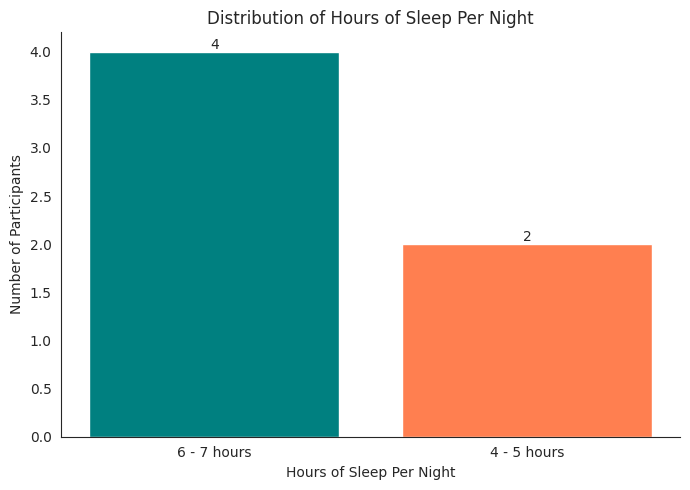

In [ ]:
#@title Hours of Sleep Per Night - Bar Chart
new_df['How many hours of sleep do you usually get per night?'] = pd.to_numeric(new_df['How many hours of sleep do you usually get per night?'], errors='coerce').fillna(0).astype(np.int64)

def number_of_sleep(sleep):
    if 1 < sleep < 4:
        return 'Less than 4 hours'
    elif 4 <= sleep <= 5:
        return '4 - 5 hours'
    elif 6 <= sleep <= 7:
        return '6 - 7 hours'
    elif sleep > 7:
        return '8 or more hours'
    else:
        return None

new_df['Sleep'] = new_df['How many hours of sleep do you usually get per night?'].apply(number_of_sleep)

num_of_sleep = new_df['Sleep'].value_counts()

plt.figure(figsize=(7, 5))  # Adjust figure size if needed

bars = plt.bar(num_of_sleep.index, num_of_sleep.values, color=['teal', 'coral', 'orange', 'lightblue'])

plt.xlabel("Hours of Sleep Per Night")
plt.ylabel("Number of Participants")
plt.title("Distribution of Hours of Sleep Per Night")

# Add labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height,
             ha='center', va='bottom')

sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

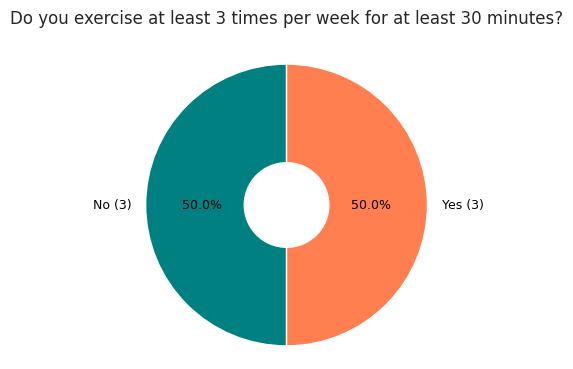

In [ ]:
#@title Number of Exercise Per Day
def num_of_exercise (exercise):
  if exercise== 'Yes':
    return 'Yes'
  elif exercise== 'No':
    return 'No'
  else:
    return None

new_df['Exercise'] = new_df['Do you exercise at least 3 times per week for at least 30 minutes?'].apply(num_of_exercise)

num_of_exercise = new_df['Exercise'].value_counts()

labels = [f'{label} ({count})' for label, count in zip(num_of_exercise.index, num_of_exercise.values)]

plt.figure(figsize=(4, 4))
plt.pie(num_of_exercise,
        labels= labels,
        autopct='%1.1f%%',
        startangle=90, colors=(['teal', 'coral']),
        wedgeprops={'linewidth': 1, 'edgecolor': 'white', 'width': 0.7},
        textprops={'fontsize': 9, 'color': 'black', 'weight': 'normal'})
plt.title('Do you exercise at least 3 times per week for at least 30 minutes?', pad= 20)

plt.axis('equal')
plt.show()

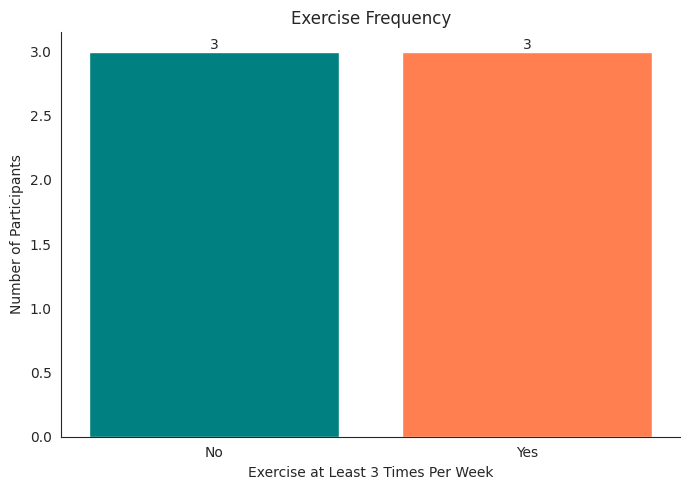

In [ ]:
#@title Number of Exercise Per Day - Bar Chart
def num_of_exercise (exercise):
  if exercise== 'Yes':
    return 'Yes'
  elif exercise== 'No':
    return 'No'
  else:
    return None

new_df['Exercise'] = new_df['Do you exercise at least 3 times per week for at least 30 minutes?'].apply(num_of_exercise)

num_of_exercise = new_df['Exercise'].value_counts()

plt.figure(figsize=(7, 5))  # Adjust figure size if needed

# Creating the bar chart
bars = plt.bar(num_of_exercise.index, num_of_exercise.values, color=['teal', 'coral'])

plt.xlabel("Exercise at Least 3 Times Per Week")
plt.ylabel("Number of Participants")
plt.title("Exercise Frequency")

# Add labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height,
             ha='center', va='bottom')

sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

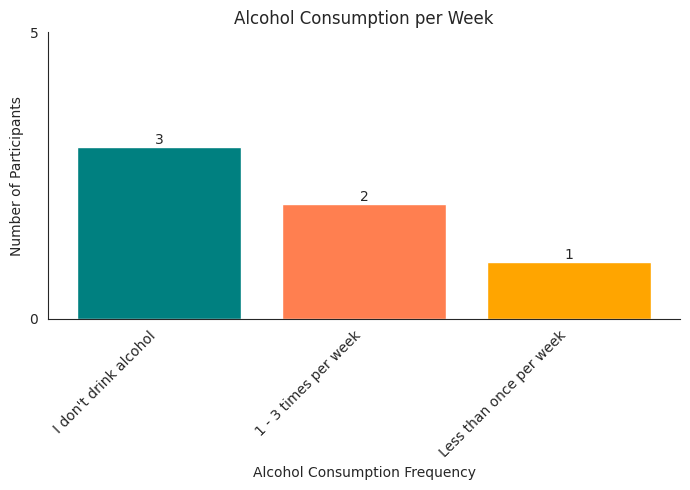

In [ ]:
#@title Bar Chart of Alcohol per Day
#new_df['How often do you drink alcohol?'] = pd.to_numeric(new_df['How often do you drink alcohol?'], errors='coerce').fillna(0).astype(np.int64)
def num_of_alcohol (alcohol):
  if alcohol== 'Less than once per week':
    return "Less than once per week"
  elif alcohol== '1 - 3 days per week':
    return '1 - 3 times per week'
  elif alcohol== "I don't drink alcohol":
    return "I don't drink alcohol"
  elif alcohol== 'Daily':
    return "Daily"
  elif alcohol== '4 - 6 days per week':
    return '4 - 6 times per week'
  else:
    return None

new_df['Alcohol Use'] = new_df['How often do you drink alcohol?'].apply(num_of_alcohol)
num_of_alcohol = new_df['Alcohol Use'].value_counts()

plt.figure(figsize=(7, 5))

bars = plt.bar(num_of_alcohol.index, num_of_alcohol.values, color=['teal', 'coral', 'orange', 'lightblue', 'red'])

plt.xlabel("Alcohol Consumption Frequency")
plt.ylabel("Number of Participants")
plt.title("Alcohol Consumption per Week")
plt.xticks(rotation=45, ha="right")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

max_y = int(max(num_of_alcohol.values))
plt.yticks(range(0, max_y + 5, 5))

sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

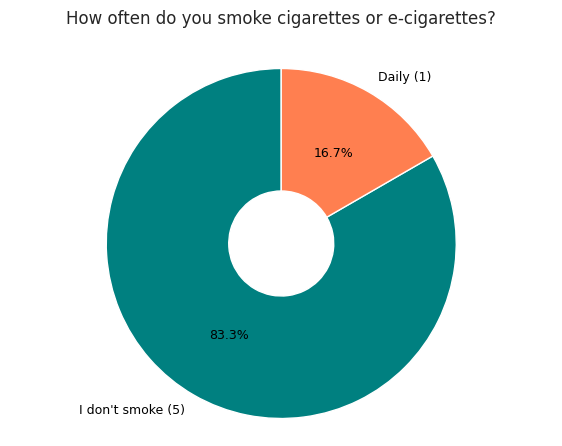

In [ ]:
#@title Pie Chart of Cigarette Use
def num_of_cigs(cigs):
  if cigs== 'Never':
    return "I don't smoke"
  elif cigs== 'Daily':
    return 'Daily'
  else:
    return None

new_df['Cigarette Use'] = new_df['How often do you smoke cigarettes or e-cigarettes?'].apply(num_of_cigs)
num_of_cigs = new_df['Cigarette Use'].value_counts()

labels = [f'{label} ({count})' for label, count in zip(num_of_cigs.index, num_of_cigs.values)]

plt.figure(figsize=(7, 5))
plt.pie(num_of_cigs,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90, colors=(['teal', 'coral', 'orange']),
        wedgeprops={'linewidth': 1, 'edgecolor': 'white', 'width': 0.7},
        textprops={'fontsize': 9, 'color': 'black', 'weight': 'normal'})
plt.title('How often do you smoke cigarettes or e-cigarettes?', pad= 20)

plt.axis('equal')
plt.show()

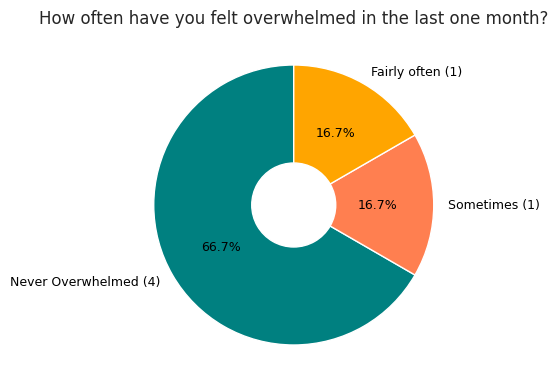

In [ ]:
#@title Pie Chart of Overwhelm
def num_of_overwhelm (over):
  if over== 'Never':
    return "Never Overwhelmed"
  elif over== 'Sometimes':
    return 'Sometimes'
  elif over== 'Fairly often':
    return 'Fairly often'
  elif over== 'Very Often':
    return 'Overwhelmed Very Often'

new_df['Feeling of Overwhelm'] = new_df['In the last month, how often have you felt overwhelmed and unable to cope with important responsibilities'].apply(num_of_overwhelm)
num_of_overwhelm = new_df['Feeling of Overwhelm'].value_counts()

labels = [f'{label} ({count})' for label, count in zip(num_of_overwhelm.index, num_of_overwhelm.values)]

plt.figure(figsize=(5, 4))
plt.pie(num_of_overwhelm,
        labels= labels,
        autopct='%1.1f%%',
        startangle=90, colors=(['teal', 'coral', 'orange']),
        wedgeprops={'linewidth': 1, 'edgecolor': 'white', 'width': 0.7},
        textprops={'fontsize': 9, 'color': 'black', 'weight': 'normal'})
plt.title('How often have you felt overwhelmed in the last one month?', pad= 20)

plt.axis('equal')
plt.show()

## Experimental Features

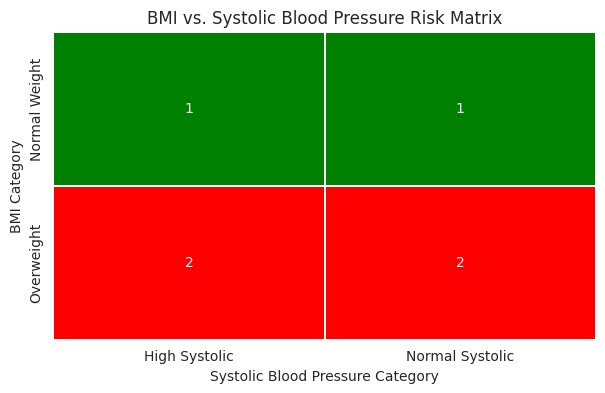

In [ ]:
#@title Chart BMI with Systolic Pressure

def create_heatmap(df):
    contingency_table = pd.crosstab(df['BMI Category'], df['SBP Category'])

    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["green", "yellow", "red"])

    # Create the heatmap
    plt.figure(figsize=(7, 4))
    sns.heatmap(contingency_table, annot=True, fmt="d", cmap=cmap, linewidths=.2, cbar= False)
    plt.title('BMI vs. Systolic Blood Pressure Risk Matrix')
    plt.xlabel('Systolic Blood Pressure Category')
    plt.ylabel('BMI Category')
    plt.show()

create_heatmap(new_df)


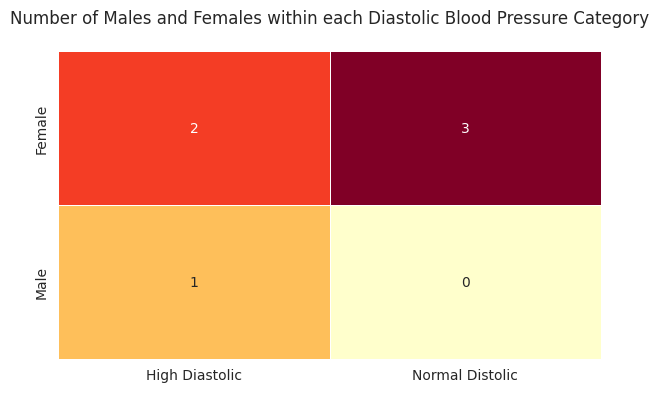

In [ ]:
def create_bmi_dbp_heatmap(df):
    # Create the contingency table
    contingency_table = pd.crosstab(df['Gender Cat'], df['DBP Category'])

    # Create the heatmap
    plt.figure(figsize=(7, 4))
    sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlOrRd", linewidths=.5, cbar= False)
    plt.title('Number of Males and Females within each Diastolic Blood Pressure Category', pad= 20)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

create_bmi_dbp_heatmap(new_df)

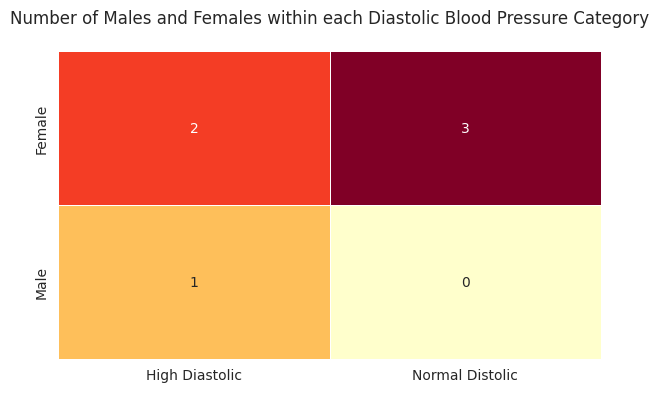

In [ ]:
def create_bmi_dbp_heatmap(df):
    contingency_table = pd.crosstab(df['Gender Cat'], df['DBP Category'])

    plt.figure(figsize=(7, 4))
    sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlOrRd", linewidths=.5, cbar= False)
    plt.title('Number of Males and Females within each Diastolic Blood Pressure Category', pad=20)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

create_bmi_dbp_heatmap(new_df)